In [1]:
import numpy as np
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear_layer = nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU())
    def forward(self, x):
        x = self.linear_layer(x)
        return x

In [3]:
class Actor(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Actor, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, a_dim))

        self.f = nn.Sequential(*layers)

    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
        out = self.f(state)
        #out = torch.tanh(out)
        out= F.softmax(out+1e-10, dim=-1)
        return out
    
    def sampling(self, state):

        probs = self(state)
        dist = Categorical(probs)
        sampled_actions = dist.sample()
        log_probs = dist.log_prob(sampled_actions).unsqueeze(1)
        return probs, log_probs


In [4]:
class QDNN(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(QDNN, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim + a_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, 1))

        self.f = nn.Sequential(*layers)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        out = self.f(x)
        return out

In [5]:
class Critic(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Critic, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        # Two DNNs to mitigate positive bias
        self.Q1 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)
        self.Q2 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)

    def forward(self, state, action):
        q1 = self.Q1(state, action)
        q2 = self.Q2(state, action)
        return q1, q2

In [6]:
class SAC():
    def __init__(self, s_dim, a_dim, hidden_dim_actor=256, hidden_dim_critic=256, 
                 num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, 
                 gamma=0.99, tau=0.005, alpha=0.2, lambd=0.005, target_upd_inter=1, 
                 buffer_capacity=1000, batch_size=32, grad_steps = 1, device="cpu"):
        
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.device = device
        self.batch_size = batch_size
        self.buffer = deque(maxlen=buffer_capacity)
        self.grad_steps = grad_steps

        self.alpha = alpha
        self.lambd = lambd
        self.gamma = gamma
        self.tau = tau
        self.target_upd_inter = target_upd_inter

        self.actor = Actor(s_dim, a_dim, hidden_dim_actor, num_hidden_layers=num_layer_actor).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_act)

        self.critic = Critic(s_dim, a_dim, hidden_dim_critic, num_hidden_layers=num_layer_critic).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_crit)

        # Stabilize training
        self.critic_target = copy.deepcopy(self.critic).to(device)
        for p in self.critic_target.parameters():
            p.requires_grad = False

    def choose_action(self, state):
        self.actor.eval()
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            action_probs = self.actor(state.to(self.device))
            dist = Categorical(action_probs)
            action = dist.sample()
        return action.item(), action_probs.squeeze().detach().cpu().numpy()

    def train(self, update_interval):
        if len(self.buffer) < self.batch_size:
            return None, None

        for i in range(self.grad_steps):
            batch = random.sample(self.buffer, self.batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.tensor(states, dtype=torch.float32).to(self.device)
            actions = torch.tensor(actions, dtype=torch.float32).squeeze().to(self.device)
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
            next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
            dones = torch.tensor(dones, dtype=torch.float32).to(self.device)
            #print(dones)
            
            # # Critic train
            # self.critic.train()
            
            with torch.no_grad():
                probs = self.actor(next_states)
                dist = Categorical(probs)
                sampled_actions = dist.sample()
                next_actions_log_probs = dist.log_prob(sampled_actions).unsqueeze(1)
                q1_next, q2_next = self.critic_target(next_states, probs)
                min_q_next = torch.min(q1_next, q2_next)
                #print((torch.ones_like(dones)-dones).shape)
                target_q_value = rewards + self.gamma *(torch.ones_like(dones)-dones).unsqueeze(1)*(min_q_next - self.alpha * next_actions_log_probs)#.sum(-1, keepdim=True))
                
            q1, q2 = self.critic(states, actions)
            
            critic_loss = F.mse_loss(q1, target_q_value.detach()) + F.mse_loss(q2, target_q_value.detach())

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Actor train
            self.actor.train()

            probs = self.actor(states)
            dist = Categorical(probs)
            sampled_actions = dist.sample()
            log_probs = dist.log_prob(sampled_actions)#.sum(-1, keepdim=True)
            q1_actor, q2_actor = self.critic(states, probs)
            min_q_actor = torch.min(q1_actor, q2_actor)
            
            actor_loss = (self.alpha * log_probs.unsqueeze(1) - min_q_actor).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # critic_loss = self.critic_train(states, actions, next_states, rewards, dones)

            # # Actor train
            # actor_loss = self.train_actor(states)

            # Soft update of target networks
            if update_interval % self.target_upd_inter == 0:
                for target_parameters, parameters in zip(self.critic_target.parameters(), self.critic.parameters()):
                    target_parameters.data.copy_(self.tau * parameters.data + (1.0 - self.tau) * target_parameters.data)

        #print(critic_loss.item(), actor_loss.item())
        return critic_loss, actor_loss
    
    def critic_train(self, states, actions, next_states, rewards, dones):
        with torch.no_grad():
            probs, actions_log_probs = self.actor.sampling(states)
            q1_next, q2_next = self.critic_target(next_states, probs)
            min_q_next = torch.min(q1_next, q2_next)
            #print((torch.ones_like(dones)-dones).shape)
            target_q_value = rewards + self.gamma *(torch.ones_like(dones)-dones).unsqueeze(1)*(min_q_next - self.alpha * actions_log_probs)#.sum(-1, keepdim=True))
                
        q1, q2 = self.critic(states, actions)
        
        critic_loss = F.mse_loss(q1, target_q_value) + F.mse_loss(q2, target_q_value)

        self.critic_optimizer.zero_grad()
        self.critic_optimizer
        critic_loss.backward()
        # torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)
        self.critic_optimizer.step()

        return critic_loss.item()
    
    def train_actor(self, states):
        probs, log_probs = self.actor.sampling(states)
        q1_actor, q2_actor = self.critic(states, probs)
        min_q_actor = torch.min(q1_actor, q2_actor)
        
        actor_loss = (self.alpha * log_probs.unsqueeze(1) - min_q_actor.detach()).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        # torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
        self.actor_optimizer.step()

        return actor_loss.item()

    def add_elements_to_buffer(self, state, probs, reward, next_state, done):
        self.buffer.append((state, probs, reward, next_state, done))

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Code for saving the scores and the plots

In [28]:
import pandas as pd
def train_SAC(agent, env, n_games, training_interval=1, update_interval=1, print_num_episodes=10):
    
    best_score = env.reward_range[0]
    score_history = []

    avg_score = 0
    n_steps = 0
    warmup = 100

    for i in range(n_games):
        state = env.reset()
        done = False
        score = 0
        for _ in range(env.spec.max_episode_steps):
            action, probs = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            
            agent.add_elements_to_buffer(state, probs, reward, next_state, done)
            state = next_state
            update_interval += 1
            n_steps += 1
            if n_steps % training_interval == 0:
                critic_loss, actor_loss = agent.train(update_interval)
            if done:
                break

        score_history.append(score)
        avg_score = np.mean(score_history[-10:])
        if i % print_num_episodes == 0:
            print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)
    
    env.close()

    return score_history

def plot_scores(mean_scores, std_scores):
    # Create the plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    episodes = np.arange(1, len(mean_scores) + 1)
    ax.plot(episodes, mean_scores, color='green', label='Mean Score')
    ax.fill_between(episodes, mean_scores - std_scores, mean_scores + std_scores, color='green', alpha=0.3, label='Std Dev')

    ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
    ax.set_xlabel('Episode #', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(fontsize=20)

    plt.show()

def run_experiments(env, agent_class, agent_kwargs, n_games=300, n_runs=3, training_interval=1, update_interval=1):
    all_scores = []
    
    for run in range(n_runs):
        # Reinitialize the agent for each run
        agent = agent_class(**agent_kwargs)
        env.seed(25)
        score_history = train_SAC(agent, env, n_games, training_interval=training_interval, update_interval=update_interval, print_num_episodes=10)
        all_scores.append(score_history)
    
    all_scores = np.array(all_scores)
    mean_scores = np.mean(all_scores, axis=0)
    std_scores = np.std(all_scores, axis=0)
    
    return mean_scores, std_scores

## Cartpole-v1

episode 0 score 11.0 avg score 11.0
episode 10 score 10.0 avg score 19.6
episode 20 score 15.0 avg score 15.1
episode 30 score 15.0 avg score 29.0
episode 40 score 322.0 avg score 160.1
episode 50 score 188.0 avg score 187.0
episode 60 score 297.0 avg score 312.4
episode 70 score 328.0 avg score 477.4
episode 80 score 500.0 avg score 467.4
episode 90 score 475.0 avg score 497.5
episode 100 score 316.0 avg score 431.3
episode 110 score 500.0 avg score 423.0
episode 120 score 500.0 avg score 467.0
episode 130 score 500.0 avg score 500.0
episode 140 score 500.0 avg score 500.0
episode 150 score 500.0 avg score 475.1
episode 160 score 500.0 avg score 500.0
episode 170 score 500.0 avg score 500.0
episode 180 score 500.0 avg score 500.0
episode 190 score 500.0 avg score 492.8
episode 200 score 500.0 avg score 495.8
episode 210 score 500.0 avg score 500.0
episode 220 score 500.0 avg score 500.0
episode 230 score 500.0 avg score 500.0
episode 240 score 500.0 avg score 500.0
episode 250 score 5

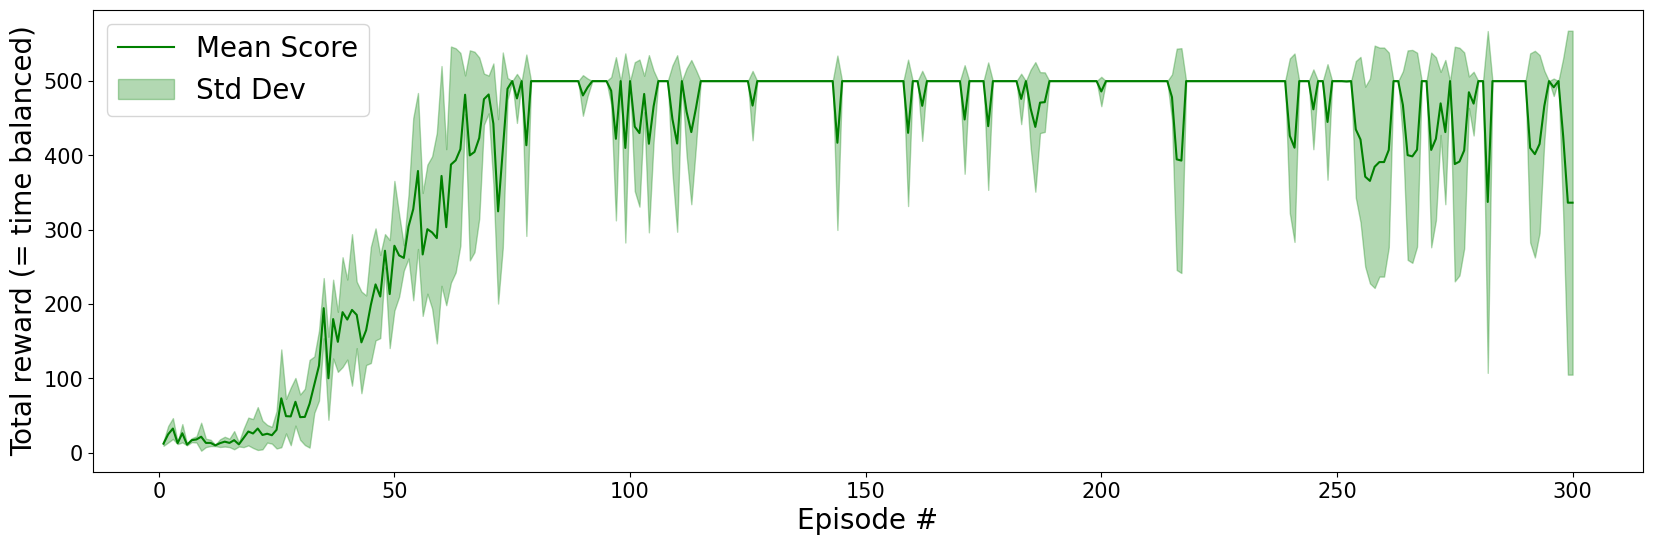

In [25]:
env = gym.make('CartPole-v1')
env.seed(25)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent_kwargs = {
    's_dim': state_dim,
    'a_dim': action_dim,
    'buffer_capacity': int(1e5),
    'hidden_dim_actor': 64,
    'hidden_dim_critic': 64,
    'num_layer_actor': 2,
    'num_layer_critic': 2,
    'lr_act': 3e-3,
    'lr_crit': 3e-3,
    'alpha': 0.2,
    'tau': 0.05,
    'batch_size': 128,
    'grad_steps': 1,
    'device': device
}

mean_scores, std_scores = run_experiments(env, SAC, agent_kwargs, n_games=300, n_runs=3, training_interval=1, update_interval=1)

# Save the results to a CSV file
df = pd.DataFrame({'Episode': np.arange(1, len(mean_scores) + 1), 'Mean Score': mean_scores, 'Std Dev': std_scores})
df.to_csv('sac_cartpolev1.csv', index=False)

# Plot the learning progress
plot_scores(mean_scores, std_scores)
env.close()

## Acrobot-v1

In [26]:
env = gym.make("Acrobot-v1")
env.seed(25)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent_kwargs = {
    's_dim': state_dim,
    'a_dim': action_dim,
    'buffer_capacity': int(1e6),
    'hidden_dim_actor': 64,
    'hidden_dim_critic': 64,
    'num_layer_actor': 1,
    'num_layer_critic': 1,
    'lr_act': 6e-4,
    'lr_crit': 6e-4,
    'alpha': 0.2,
    'tau': 0.05,
    'batch_size': 64,
    'grad_steps': 2,
    'device': device
}

mean_scores, std_scores = run_experiments(env, SAC, agent_kwargs, n_games=300, n_runs=3, training_interval=2, update_interval=1)

# Save the results to a CSV file
df = pd.DataFrame({'Episode': np.arange(1, len(mean_scores) + 1), 'Mean Score': mean_scores, 'Std Dev': std_scores})
df.to_csv('sac_acrobot.csv', index=False)

agent = SAC(state_dim, action_dim, buffer_capacity=int(1e6), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=1, num_layer_critic=1, lr_act=6e-4, lr_crit=6e-4, alpha=0.2, tau=0.05, batch_size=64, 
            grad_steps=2, device=device)

# Plot the learning progress
plot_scores(mean_scores, std_scores)
env.close()

c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\

episode 0 score -500.0 avg score -500.0
episode 10 score -174.0 avg score -257.9
episode 20 score -382.0 avg score -312.8
episode 30 score -209.0 avg score -358.7
episode 40 score -293.0 avg score -262.6
episode 50 score -319.0 avg score -287.6
episode 60 score -357.0 avg score -222.0
episode 70 score -295.0 avg score -292.4
episode 80 score -320.0 avg score -258.7


KeyboardInterrupt: 

## Cartpole-v1

In [ ]:
### Plot the learning progress
def plot_scores(score_history):
    # Create the plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    # Plot the scores with specified colors and labels
    ax.plot(np.arange(1, len(score_history) + 1), score_history, color='green', label='SAC')

    # Set the labels with a larger font size
    ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
    ax.set_xlabel('Episode #', fontsize=20)

    # Set the tick labels to a larger font size
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Add a legend with a specified font size
    ax.legend(fontsize=20)

    # Show the plot
    plt.show()

def train_SAC(agent, env, n_games, episode_length, training_interval=1, update_interval=1, print_num_episodes=10):
    #env.seed(seed=0)
    n_games = n_games

    best_score = env.reward_range[0]
    score_history = []

    avg_score = 0
    n_steps = 0
    training_interval=training_interval
    update_interval = update_interval


    for i in range(n_games):
        state = env.reset()
        done = False
        score = 0
        for _ in range(episode_length):
            action, probs = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            agent.add_elements_to_buffer(state, probs, reward, next_state, done)
            state = next_state
            update_interval += 1
            n_steps += 1
            if n_steps % training_interval == 0:
                critic_loss, actor_loss = agent.train(update_interval)
            if done:
                break

        score_history.append(score)
        avg_score = np.mean(score_history[-5:])
        if i%print_num_episodes == 0:
            print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)
            #print(critic_loss, actor_loss)
    
    env.close()

    return score_history

In [12]:
env = gym.make("CartPole-v1")
env.seed(25)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = SAC(state_dim, action_dim, buffer_capacity=int(1e6), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, alpha=0.2, tau=0.05, batch_size=64, 
            grad_steps=4, device=device)
            

score_history = train_SAC(agent, env, 300, 500, training_interval=1, update_interval=1, print_num_episodes=1)
plot_scores(score_history)

c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\

episode 0 score 20.0 avg score 20.0
episode 1 score 19.0 avg score 19.5
episode 2 score 18.0 avg score 19.0
episode 3 score 11.0 avg score 17.0
episode 4 score 12.0 avg score 16.0
episode 5 score 10.0 avg score 14.0
episode 6 score 17.0 avg score 13.6
episode 7 score 16.0 avg score 13.2
episode 8 score 12.0 avg score 13.4
episode 9 score 14.0 avg score 13.8
episode 10 score 13.0 avg score 14.4
episode 11 score 11.0 avg score 13.2
episode 12 score 58.0 avg score 21.6
episode 13 score 12.0 avg score 21.6
episode 14 score 39.0 avg score 26.6
episode 15 score 93.0 avg score 42.6
episode 16 score 72.0 avg score 54.8
episode 17 score 52.0 avg score 53.6
episode 18 score 87.0 avg score 68.6
episode 19 score 91.0 avg score 79.0
episode 20 score 80.0 avg score 76.4
episode 21 score 57.0 avg score 73.4
episode 22 score 157.0 avg score 94.4
episode 23 score 246.0 avg score 126.2
episode 24 score 140.0 avg score 136.0
episode 25 score 103.0 avg score 140.6
episode 26 score 268.0 avg score 182.8
ep

KeyboardInterrupt: 

In [13]:
import csv

# Provided data
data = """
episode 0 score 20.0 avg score 20.0
episode 1 score 19.0 avg score 19.5
episode 2 score 18.0 avg score 19.0
episode 3 score 11.0 avg score 17.0
episode 4 score 12.0 avg score 16.0
episode 5 score 10.0 avg score 14.0
episode 6 score 17.0 avg score 13.6
episode 7 score 16.0 avg score 13.2
episode 8 score 12.0 avg score 13.4
episode 9 score 14.0 avg score 13.8
episode 10 score 13.0 avg score 14.4
episode 11 score 11.0 avg score 13.2
episode 12 score 58.0 avg score 21.6
episode 13 score 12.0 avg score 21.6
episode 14 score 39.0 avg score 26.6
episode 15 score 93.0 avg score 42.6
episode 16 score 72.0 avg score 54.8
episode 17 score 52.0 avg score 53.6
episode 18 score 87.0 avg score 68.6
episode 19 score 91.0 avg score 79.0
episode 20 score 80.0 avg score 76.4
episode 21 score 57.0 avg score 73.4
episode 22 score 157.0 avg score 94.4
episode 23 score 246.0 avg score 126.2
episode 24 score 140.0 avg score 136.0
episode 25 score 103.0 avg score 140.6
episode 26 score 268.0 avg score 182.8
episode 27 score 271.0 avg score 205.6
episode 28 score 221.0 avg score 200.6
episode 29 score 210.0 avg score 214.6
episode 30 score 155.0 avg score 225.0
episode 31 score 176.0 avg score 206.6
episode 32 score 251.0 avg score 202.6
episode 33 score 294.0 avg score 217.2
episode 34 score 372.0 avg score 249.6
episode 35 score 283.0 avg score 275.2
episode 36 score 200.0 avg score 280.0
episode 37 score 273.0 avg score 284.4
episode 38 score 227.0 avg score 271.0
episode 39 score 282.0 avg score 253.0
episode 40 score 263.0 avg score 249.0
episode 41 score 282.0 avg score 265.4
episode 42 score 238.0 avg score 258.4
episode 43 score 174.0 avg score 247.8
episode 44 score 279.0 avg score 247.2
episode 45 score 265.0 avg score 247.6
episode 46 score 257.0 avg score 242.6
episode 47 score 298.0 avg score 254.6
episode 48 score 369.0 avg score 293.6
episode 49 score 500.0 avg score 337.8
episode 50 score 500.0 avg score 384.8
episode 51 score 500.0 avg score 433.4
episode 52 score 500.0 avg score 473.8
episode 53 score 500.0 avg score 500.0
episode 54 score 500.0 avg score 500.0
episode 55 score 59.0 avg score 411.8
episode 56 score 476.0 avg score 407.0
episode 57 score 214.0 avg score 349.8
episode 58 score 211.0 avg score 292.0
episode 59 score 238.0 avg score 239.6
episode 60 score 500.0 avg score 327.8
episode 61 score 500.0 avg score 332.6
episode 62 score 500.0 avg score 389.8
episode 63 score 500.0 avg score 447.6
episode 64 score 500.0 avg score 500.0
episode 65 score 190.0 avg score 438.0
episode 66 score 500.0 avg score 438.0
episode 67 score 500.0 avg score 438.0
episode 68 score 500.0 avg score 438.0
episode 69 score 500.0 avg score 438.0
episode 70 score 500.0 avg score 500.0
episode 71 score 500.0 avg score 500.0
episode 72 score 500.0 avg score 500.0
episode 73 score 500.0 avg score 500.0
episode 74 score 500.0 avg score 500.0
episode 75 score 500.0 avg score 500.0
episode 76 score 500.0 avg score 500.0
episode 77 score 500.0 avg score 500.0
episode 78 score 500.0 avg score 500.0
episode 79 score 500.0 avg score 500.0
episode 80 score 500.0 avg score 500.0
episode 81 score 500.0 avg score 500.0
episode 82 score 500.0 avg score 500.0
episode 83 score 500.0 avg score 500.0
episode 84 score 500.0 avg score 500.0
episode 85 score 500.0 avg score 500.0
episode 86 score 500.0 avg score 500.0
episode 87 score 500.0 avg score 500.0
episode 88 score 500.0 avg score 500.0
episode 89 score 500.0 avg score 500.0
episode 90 score 500.0 avg score 500.0
episode 91 score 500.0 avg score 500.0
episode 92 score 500.0 avg score 500.0
episode 93 score 500.0 avg score 500.0
episode 94 score 500.0 avg score 500.0
episode 95 score 500.0 avg score 500.0
episode 96 score 500.0 avg score 500.0
episode 97 score 500.0 avg score 500.0
episode 98 score 500.0 avg score 500.0
episode 99 score 500.0 avg score 500.0
episode 100 score 311.0 avg score 462.2
episode 101 score 500.0 avg score 462.2
episode 102 score 500.0 avg score 462.2
episode 103 score 500.0 avg score 462.2
episode 104 score 500.0 avg score 462.2
episode 105 score 500.0 avg score 500.0
episode 106 score 500.0 avg score 500.0
episode 107 score 500.0 avg score 500.0
episode 108 score 500.0 avg score 500.0
episode 109 score 500.0 avg score 500.0
episode 110 score 500.0 avg score 500.0
episode 111 score 500.0 avg score 500.0
episode 112 score 500.0 avg score 500.0
episode 113 score 500.0 avg score 500.0
episode 114 score 500.0 avg score 500.0
episode 115 score 500.0 avg score 500.0
"""

# Extract scores from the provided data
lines = data.strip().split('\n')
scores = []

for line in lines:
    parts = line.split()
    score_index = parts.index('score') + 1
    scores.append(parts[score_index])

# Write scores to a CSV file
with open('cartpoleT3.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['score'])
    for score in scores:
        writer.writerow([score])

print("Scores have been written to scores.csv")

Scores have been written to scores.csv


## Acrobot

In [55]:
env = gym.make("Acrobot-v1")
env.seed(25)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = SAC(state_dim, action_dim, buffer_capacity=int(1e5), hidden_dim_actor = 256, hidden_dim_critic=256, 
            num_layer_actor=1, num_layer_critic=1, lr_act=3e-4, lr_crit=3e-4, alpha=0.2, tau=0.03, batch_size=128, 
            grad_steps=1, device=device)

score_history = train_SAC(agent, env, 500, training_interval=1, update_interval=1, print_num_episodes=1)
plot_scores(score_history)

episode 0 score -418.0 avg score -418.0
episode 1 score -500.0 avg score -459.0
episode 2 score -246.0 avg score -388.0
episode 3 score -500.0 avg score -416.0
episode 4 score -365.0 avg score -405.8
episode 5 score -244.0 avg score -378.8
episode 6 score -273.0 avg score -363.7
episode 7 score -259.0 avg score -350.6
episode 8 score -286.0 avg score -343.4
episode 9 score -318.0 avg score -340.9
episode 10 score -219.0 avg score -321.0
episode 11 score -244.0 avg score -295.4
episode 12 score -200.0 avg score -290.8
episode 13 score -252.0 avg score -266.0
episode 14 score -161.0 avg score -245.6
episode 15 score -228.0 avg score -244.0
episode 16 score -300.0 avg score -246.7
episode 17 score -190.0 avg score -239.8
episode 18 score -259.0 avg score -237.1
episode 19 score -136.0 avg score -218.9
episode 20 score -141.0 avg score -211.1
episode 21 score -177.0 avg score -204.4
episode 22 score -150.0 avg score -199.4
episode 23 score -151.0 avg score -189.3
episode 24 score -175.0 av

In [47]:
env.close()

In [15]:
import csv

# Provided data
data = """
episode 0 score -273.0 avg score -273.0
episode 1 score -77.0 avg score -175.0
episode 2 score -97.0 avg score -149.0
episode 3 score -159.0 avg score -151.5
episode 4 score -167.0 avg score -154.6
episode 5 score -96.0 avg score -119.2
episode 6 score -267.0 avg score -157.2
episode 7 score -117.0 avg score -161.2
episode 8 score -97.0 avg score -148.8
episode 9 score -83.0 avg score -132.0
episode 10 score -101.0 avg score -133.0
episode 11 score -122.0 avg score -104.0
episode 12 score -118.0 avg score -104.2
episode 13 score -106.0 avg score -106.0
episode 14 score -121.0 avg score -113.6
episode 15 score -115.0 avg score -116.4
episode 16 score -198.0 avg score -131.6
episode 17 score -141.0 avg score -136.2
episode 18 score -109.0 avg score -136.8
episode 19 score -136.0 avg score -139.8
episode 20 score -86.0 avg score -134.0
episode 21 score -88.0 avg score -112.0
episode 22 score -94.0 avg score -102.6
episode 23 score -100.0 avg score -100.8
episode 24 score -102.0 avg score -94.0
episode 25 score -119.0 avg score -100.6
episode 26 score -99.0 avg score -102.8
episode 27 score -90.0 avg score -102.0
episode 28 score -101.0 avg score -102.2
episode 29 score -111.0 avg score -104.0
episode 30 score -119.0 avg score -104.0
episode 31 score -99.0 avg score -104.0
episode 32 score -103.0 avg score -106.6
episode 33 score -126.0 avg score -111.6
episode 34 score -110.0 avg score -111.4
episode 35 score -68.0 avg score -101.2
episode 36 score -99.0 avg score -101.2
episode 37 score -87.0 avg score -98.0
episode 38 score -97.0 avg score -92.2
episode 39 score -153.0 avg score -100.8
episode 40 score -88.0 avg score -104.8
episode 41 score -84.0 avg score -101.8
episode 42 score -95.0 avg score -103.4
episode 43 score -105.0 avg score -105.0
episode 44 score -500.0 avg score -174.4
episode 45 score -101.0 avg score -177.0
episode 46 score -106.0 avg score -181.4
episode 47 score -119.0 avg score -186.2
episode 48 score -89.0 avg score -183.0
episode 49 score -103.0 avg score -103.6
episode 50 score -96.0 avg score -102.6
episode 51 score -99.0 avg score -101.2
episode 52 score -85.0 avg score -94.4
episode 53 score -87.0 avg score -94.0
episode 54 score -94.0 avg score -92.2
episode 55 score -87.0 avg score -90.4
episode 56 score -95.0 avg score -89.6
episode 57 score -96.0 avg score -91.8
episode 58 score -116.0 avg score -97.6
episode 59 score -116.0 avg score -102.0
episode 60 score -145.0 avg score -113.6
episode 61 score -87.0 avg score -112.0
episode 62 score -93.0 avg score -111.4
episode 63 score -108.0 avg score -109.8
episode 64 score -79.0 avg score -102.4
episode 65 score -88.0 avg score -91.0
episode 66 score -101.0 avg score -93.8
episode 67 score -133.0 avg score -101.8
episode 68 score -90.0 avg score -98.2
episode 69 score -94.0 avg score -101.2
episode 70 score -88.0 avg score -101.2
episode 71 score -112.0 avg score -103.4
episode 72 score -112.0 avg score -99.2
episode 73 score -123.0 avg score -105.8
episode 74 score -123.0 avg score -111.6
episode 75 score -93.0 avg score -112.6
episode 76 score -86.0 avg score -107.4
episode 77 score -100.0 avg score -105.0
episode 78 score -98.0 avg score -100.0
episode 79 score -93.0 avg score -94.0
episode 80 score -101.0 avg score -95.6
episode 81 score -86.0 avg score -95.6
episode 82 score -89.0 avg score -93.4
episode 83 score -82.0 avg score -90.2
episode 84 score -87.0 avg score -89.0
episode 85 score -124.0 avg score -93.6
episode 86 score -126.0 avg score -101.6
episode 87 score -107.0 avg score -105.2
episode 88 score -84.0 avg score -105.6
episode 89 score -92.0 avg score -106.6
episode 90 score -100.0 avg score -101.8
episode 91 score -132.0 avg score -103.0
episode 92 score -98.0 avg score -101.2
episode 93 score -92.0 avg score -102.8
episode 94 score -83.0 avg score -101.0
episode 95 score -122.0 avg score -105.4
episode 96 score -81.0 avg score -95.2
episode 97 score -81.0 avg score -91.8
episode 98 score -103.0 avg score -94.0
episode 99 score -102.0 avg score -97.8
episode 100 score -103.0 avg score -94.0
episode 101 score -166.0 avg score -111.0
episode 102 score -89.0 avg score -112.6
episode 103 score -93.0 avg score -110.6
episode 104 score -82.0 avg score -106.6
episode 105 score -108.0 avg score -107.6
episode 106 score -81.0 avg score -90.6
episode 107 score -82.0 avg score -89.2
episode 108 score -77.0 avg score -86.0
episode 109 score -99.0 avg score -89.4
episode 110 score -80.0 avg score -83.8
episode 111 score -77.0 avg score -83.0
episode 112 score -74.0 avg score -81.4
episode 113 score -94.0 avg score -84.8
episode 114 score -111.0 avg score -87.2
episode 115 score -81.0 avg score -87.4
episode 116 score -103.0 avg score -92.6
episode 117 score -94.0 avg score -96.6
episode 118 score -104.0 avg score -98.6
episode 119 score -87.0 avg score -93.8
episode 120 score -85.0 avg score -94.6
episode 121 score -62.0 avg score -86.4
episode 122 score -76.0 avg score -82.8
episode 123 score -64.0 avg score -74.8
episode 124 score -90.0 avg score -75.4
episode 125 score -78.0 avg score -74.0
episode 126 score -86.0 avg score -78.8
episode 127 score -78.0 avg score -79.2
episode 128 score -85.0 avg score -83.4
episode 129 score -83.0 avg score -82.0
episode 130 score -79.0 avg score -82.2
episode 131 score -78.0 avg score -80.6
episode 132 score -95.0 avg score -84.0
episode 133 score -183.0 avg score -103.6
episode 134 score -75.0 avg score -102.0
episode 135 score -90.0 avg score -104.2
episode 136 score -95.0 avg score -107.6
episode 137 score -85.0 avg score -105.6
episode 138 score -104.0 avg score -89.8
episode 139 score -97.0 avg score -94.2
episode 140 score -97.0 avg score -95.6
episode 141 score -83.0 avg score -93.2
episode 142 score -73.0 avg score -90.8
episode 143 score -151.0 avg score -100.2
episode 144 score -86.0 avg score -98.0
episode 145 score -71.0 avg score -92.8
episode 146 score -72.0 avg score -90.6
episode 147 score -75.0 avg score -91.0
episode 148 score -78.0 avg score -76.4
episode 149 score -96.0 avg score -78.4
episode 150 score -88.0 avg score -81.8
episode 151 score -74.0 avg score -82.2
episode 152 score -98.0 avg score -86.8
episode 153 score -109.0 avg score -93.0
episode 154 score -82.0 avg score -90.2
episode 155 score -132.0 avg score -99.0
episode 156 score -480.0 avg score -180.2
episode 157 score -96.0 avg score -179.8
episode 158 score -177.0 avg score -193.4
episode 159 score -84.0 avg score -193.8
episode 160 score -72.0 avg score -181.8
episode 161 score -90.0 avg score -103.8
episode 162 score -85.0 avg score -101.6
episode 163 score -74.0 avg score -81.0
episode 164 score -111.0 avg score -86.4
episode 165 score -84.0 avg score -88.8
episode 166 score -93.0 avg score -89.4
episode 167 score -75.0 avg score -87.4
episode 168 score -87.0 avg score -90.0
episode 169 score -84.0 avg score -84.6
episode 170 score -86.0 avg score -85.0
episode 171 score -88.0 avg score -84.0
episode 172 score -249.0 avg score -118.8
episode 173 score -89.0 avg score -119.2
episode 174 score -95.0 avg score -121.4
episode 175 score -129.0 avg score -130.0
episode 176 score -74.0 avg score -127.2
episode 177 score -104.0 avg score -98.2
episode 178 score -79.0 avg score -96.2
episode 179 score -97.0 avg score -96.6
episode 180 score -86.0 avg score -88.0
episode 181 score -93.0 avg score -91.8
episode 182 score -89.0 avg score -88.8
episode 183 score -79.0 avg score -88.8
episode 184 score -93.0 avg score -88.0
episode 185 score -75.0 avg score -85.8
episode 186 score -63.0 avg score -79.8
episode 187 score -84.0 avg score -78.8
episode 188 score -83.0 avg score -79.6
episode 189 score -97.0 avg score -80.4
episode 190 score -65.0 avg score -78.4
episode 191 score -86.0 avg score -83.0
episode 192 score -94.0 avg score -85.0
episode 193 score -79.0 avg score -84.2
episode 194 score -64.0 avg score -77.6
episode 195 score -64.0 avg score -77.4
episode 196 score -74.0 avg score -75.0
episode 197 score -133.0 avg score -82.8
episode 198 score -93.0 avg score -85.6
episode 199 score -77.0 avg score -88.2
episode 200 score -86.0 avg score -92.6
episode 201 score -90.0 avg score -95.8
episode 202 score -97.0 avg score -88.6
episode 203 score -75.0 avg score -85.0
episode 204 score -90.0 avg score -87.6
episode 205 score -122.0 avg score -94.8
episode 206 score -86.0 avg score -94.0
episode 207 score -93.0 avg score -93.2
episode 208 score -70.0 avg score -92.2
episode 209 score -118.0 avg score -97.8
episode 210 score -86.0 avg score -90.6
episode 211 score -90.0 avg score -91.4
episode 212 score -78.0 avg score -88.4
episode 213 score -71.0 avg score -88.6
episode 214 score -74.0 avg score -79.8
episode 215 score -88.0 avg score -80.2
episode 216 score -87.0 avg score -79.6
episode 217 score -92.0 avg score -82.4
episode 218 score -88.0 avg score -85.8
episode 219 score -78.0 avg score -86.6
episode 220 score -78.0 avg score -84.6
episode 221 score -96.0 avg score -86.4
episode 222 score -83.0 avg score -84.6
episode 223 score -84.0 avg score -83.8
episode 224 score -87.0 avg score -85.6
episode 225 score -93.0 avg score -88.6
episode 226 score -103.0 avg score -90.0
episode 227 score -315.0 avg score -136.4
episode 228 score -82.0 avg score -136.0
episode 229 score -69.0 avg score -132.4
episode 230 score -83.0 avg score -130.4
episode 231 score -84.0 avg score -126.6
episode 232 score -74.0 avg score -78.4
episode 233 score -63.0 avg score -74.6
episode 234 score -100.0 avg score -80.8
episode 235 score -107.0 avg score -85.6
episode 236 score -84.0 avg score -85.6
episode 237 score -89.0 avg score -88.6
episode 238 score -88.0 avg score -93.6
episode 239 score -84.0 avg score -90.4
episode 240 score -95.0 avg score -88.0
episode 241 score -117.0 avg score -94.6
episode 242 score -94.0 avg score -95.6
episode 243 score -63.0 avg score -90.6
episode 244 score -84.0 avg score -90.6
episode 245 score -85.0 avg score -88.6
episode 246 score -75.0 avg score -80.2
episode 247 score -84.0 avg score -78.2
episode 248 score -85.0 avg score -82.6
episode 249 score -82.0 avg score -82.2
episode 250 score -112.0 avg score -87.6
episode 251 score -82.0 avg score -89.0
episode 252 score -88.0 avg score -89.8
episode 253 score -74.0 avg score -87.6
episode 254 score -83.0 avg score -87.8
episode 255 score -75.0 avg score -80.4
episode 256 score -131.0 avg score -90.2
episode 257 score -84.0 avg score -89.4
episode 258 score -82.0 avg score -91.0
episode 259 score -130.0 avg score -100.4
episode 260 score -96.0 avg score -104.6
episode 261 score -74.0 avg score -93.2
episode 262 score -74.0 avg score -91.2
episode 263 score -80.0 avg score -90.8
episode 264 score -64.0 avg score -77.6
episode 265 score -71.0 avg score -72.6
episode 266 score -97.0 avg score -77.2
episode 267 score -96.0 avg score -81.6
episode 268 score -92.0 avg score -84.0
episode 269 score -75.0 avg score -86.2
episode 270 score -96.0 avg score -91.2
episode 271 score -85.0 avg score -88.8
episode 272 score -103.0 avg score -90.2
episode 273 score -86.0 avg score -89.0
episode 274 score -87.0 avg score -91.4
episode 275 score -70.0 avg score -86.2
episode 276 score -88.0 avg score -86.8
episode 277 score -82.0 avg score -82.6
episode 278 score -90.0 avg score -83.4
episode 279 score -86.0 avg score -83.2
episode 280 score -95.0 avg score -88.2
episode 281 score -208.0 avg score -112.2
episode 282 score -111.0 avg score -118.0
episode 283 score -75.0 avg score -115.0
episode 284 score -72.0 avg score -112.2
episode 285 score -90.0 avg score -111.2
episode 286 score -94.0 avg score -88.4
episode 287 score -82.0 avg score -82.6
episode 288 score -79.0 avg score -83.4
episode 289 score -82.0 avg score -85.4
episode 290 score -95.0 avg score -86.4
episode 291 score -96.0 avg score -86.8
episode 292 score -85.0 avg score -87.4
episode 293 score -82.0 avg score -88.0
episode 294 score -81.0 avg score -87.8
episode 295 score -79.0 avg score -84.6
episode 296 score -94.0 avg score -84.2
episode 297 score -95.0 avg score -86.2
episode 298 score -95.0 avg score -88.8
episode 299 score -85.0 avg score -89.6
"""

# Extract scores from the provided data
lines = data.strip().split('\n')
scores = []

for line in lines:
    parts = line.split()
    score_index = parts.index('score') + 1
    scores.append(parts[score_index])

# Write scores to a CSV file
with open('acrobotT3.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['score'])
    for score in scores:
        writer.writerow([score])

print("Scores have been written to scores.csv")

Scores have been written to scores.csv
